Deconvolution Training and Reconstructions with ODP
===================================================

This example demonstrates the training and application of the unrolled
optimization with deep priors (ODP) with proximal map architecture
described in <cite data-cite="diamond-2018-odp"/> for a deconvolution (deblurring)
problem.

The source images are foam phantoms generated with xdesign.

A class
[scico.flax.ODPNet](../_autosummary/scico.flax.rst#scico.flax.ODPNet)
implements the ODP architecture, which solves the optimization problem

$$\mathrm{argmin}_{\mathbf{x}} \; \| A \mathbf{x} - \mathbf{y} \|_2^2
+ r(\mathbf{x}) \;,$$

where $A$ is a circular convolution, $\mathbf{y}$ is a set of blurred
images, $r$ is a regularizer and $\mathbf{x}$ is the set of deblurred
images. The ODP, proximal map architecture, abstracts the iterative
solution by an unrolled network where each iteration corresponds to a
different stage in the ODP network and updates the prediction by
solving

$$\mathbf{x}^{k+1} = \mathrm{argmin}_{\mathbf{x}} \; \alpha_k \| A
\mathbf{x} - \mathbf{y} \|_2^2 + \frac{1}{2} \| \mathbf{x} -
\mathbf{x}^k - \mathbf{x}^{k+1/2} \|_2^2 \;,$$

which for the deconvolution problem corresponds to

$$\mathbf{x}^{k+1} = \mathcal{F}^{-1} \mathrm{diag} (\alpha_k |
\mathcal{K}|^2 + 1 )^{-1} \mathcal{F} \, (\alpha_k K^T * \mathbf{y} +
\mathbf{x}^k + \mathbf{x}^{k+1/2}) \;,$$

where $k$ is the index of the stage (iteration), $\mathbf{x}^k +
\mathbf{x}^{k+1/2} = \mathrm{ResNet}(\mathbf{x}^{k})$ is the
regularization (implemented as a residual convolutional neural network),
$\mathbf{x}^k$ is the output of the previous stage, $\alpha_k > 0$ is a
learned stage-wise parameter weighting the contribution of the fidelity
term, $\mathcal{F}$ is the DFT, $K$ is the blur kernel, and
$\mathcal{K}$ is the DFT of $K$. The output of the final stage is the
set of deblurred images.

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install git+https://github.com/lanl/scico
!pip install ray

# isort: off
import os
from functools import partial
from time import time

import numpy as np

import logging
import ray

ray.init(logging_level=logging.ERROR)  # need to call init before jax import: ray-project/ray#44087

# Set an arbitrary processor count (only applies if GPU is not available).
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

import jax

try:
    from jax.extend.backend import get_backend  # introduced in jax 0.4.33
except ImportError:
    from jax.lib.xla_bridge import get_backend

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scico import flax as sflax
from scico import metric, plot
from scico.flax.examples import load_blur_data
from scico.flax.train.traversals import clip_positive, construct_traversal
from scico.linop import CircularConvolve
plot.config_notebook_plotting()


platform = get_backend().platform
print("Platform: ", platform)

Platform:  gpu


Define blur operator.

In [2]:
output_size = 256  # patch size

n = 3  # convolution kernel size
σ = 20.0 / 255  # noise level
psf = np.ones((n, n)) / (n * n)  # blur kernel

ishape = (output_size, output_size)
opBlur = CircularConvolve(h=psf, input_shape=ishape)
opBlur_vmap = jax.vmap(opBlur)  # for batch processing in data generation

Read data from cache or generate if not available.

In [3]:
train_nimg = 416  # number of training images
test_nimg = 64  # number of testing images
nimg = train_nimg + test_nimg

train_ds, test_ds = load_blur_data(
    train_nimg,
    test_nimg,
    output_size,
    psf,
    σ,
    verbose=True,
)

Platform                  :   gpu
Device count              :   8
Data generation    time[s]:   178.86
Blur generation    time[s]:     2.38


Storing data in path: ~/.cache/scico/examples/data
Set --training-- size: 416
Set --testing -- size: 64
Data range -- images --  Min:  0.00  Max:  1.00
Data range -- labels --  Min:  0.00  Max:  1.00


Define configuration dictionary for model and training loop.

Parameters have been selected for demonstration purposes and relatively
short training. The model depth is akin to the number of unrolled
iterations in the ODP model. The block depth controls the number of
layers at each unrolled iteration. The number of filters is uniform
throughout the iterations. Better performance may be obtained by
increasing depth, block depth, number of filters or training epochs, but
may require longer training times.

In [4]:
# model configuration
model_conf = {
    "depth": 2,
    "num_filters": 64,
    "block_depth": 3,
}
# training configuration
train_conf: sflax.ConfigDict = {
    "seed": 0,
    "opt_type": "SGD",
    "momentum": 0.9,
    "batch_size": 16,
    "num_epochs": 50,
    "base_learning_rate": 1e-2,
    "warmup_epochs": 0,
    "log_every_steps": 100,
    "log": True,
    "checkpointing": True,
}

Construct ODPNet model.

In [5]:
channels = train_ds["image"].shape[-1]
model = sflax.ODPNet(
    operator=opBlur,
    depth=model_conf["depth"],
    channels=channels,
    num_filters=model_conf["num_filters"],
    block_depth=model_conf["block_depth"],
    odp_block=sflax.inverse.ODPProxDcnvBlock,
)

Construct functionality for ensuring that the learned fidelity weight
parameter is always positive.

In [6]:
alphatrav = construct_traversal("alpha")  # select alpha parameters in model
alphapos = partial(
    clip_positive,  # apply this function
    traversal=alphatrav,  # to alpha parameters in model
    minval=1e-3,
)

Run training loop.

In [7]:
print(f"\nJAX process: {jax.process_index()}{' / '}{jax.process_count()}")
print(f"JAX local devices: {jax.local_devices()}\n")

workdir = os.path.join(os.path.expanduser("~"), ".cache", "scico", "examples", "odp_dcnv_out")
train_conf["workdir"] = workdir
train_conf["post_lst"] = [alphapos]
# Construct training object
trainer = sflax.BasicFlaxTrainer(
    train_conf,
    model,
    train_ds,
    test_ds,
)
modvar, stats_object = trainer.train()


JAX process: 0 / 1
JAX local devices: [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3), CudaDevice(id=4), CudaDevice(id=5), CudaDevice(id=6), CudaDevice(id=7)]



channels: 1   training signals: 416   testing signals: 64   signal size: 256



Network Structure:
+-----------------------------------------------------------+----------------+--------+-----------+--------+
| Name                                                      | Shape          | Size   | Mean      | Std    |
+-----------------------------------------------------------+----------------+--------+-----------+--------+
| ODPProxDcnvBlock_0/alpha                                  | (1,)           | 1      | 0.5       | 0.0    |
| ODPProxDcnvBlock_0/resnet/BatchNorm_0/bias                | (1,)           | 1      | 0.0       | 0.0    |
| ODPProxDcnvBlock_0/resnet/BatchNorm_0/scale               | (1,)           | 1      | 1.0       | 0.0    |
| ODPProxDcnvBlock_0/resnet/ConvBNBlock_0/BatchNorm_0/bias  | (64,)          | 64     | 0.0       | 0.0    |
| ODPProxDcnvBlock_0/resnet/ConvBNBlock_0/BatchNorm_0/scale | (64,)          | 64     | 1.0       | 0.0    |
| ODPProxDcnvBlock_0/resnet/ConvBNBlock_0/Conv_0/kernel     | (3, 3, 1, 64)  | 576    | -0.00178  | 0.0562 |


Initial compilation completed.



Epoch  Time      Train_LR  Train_Loss  Train_SNR  Eval_Loss  Eval_SNR
---------------------------------------------------------------------
    3  9.18e+00  0.010000    0.083428       9.14   0.045592      3.31


    7  1.35e+01  0.010000    0.005438      12.54   0.065219      1.75


   11  1.67e+01  0.010000    0.004411      13.45   0.096441      0.05


   15  1.96e+01  0.010000    0.003819      14.07   0.119098     -0.86


   19  2.25e+01  0.010000    0.003427      14.54   0.101819     -0.18


   23  2.56e+01  0.010000    0.003149      14.91   0.049351      2.96


   26  2.85e+01  0.010000    0.002949      15.19   0.019000      7.11


   30  3.19e+01  0.010000    0.002797      15.42   0.007688     11.04


   34  3.48e+01  0.010000    0.002685      15.60   0.004246     13.62


   38  3.77e+01  0.010000    0.002593      15.75   0.003105     14.98


   42  4.07e+01  0.010000    0.002514      15.88   0.002743     15.51


   46  4.38e+01  0.010000    0.002450      15.99   0.002565     15.81


   49  4.67e+01  0.010000    0.002395      16.09   0.002471     15.97


Evaluate on testing data.

In [8]:
del train_ds["image"]
del train_ds["label"]

fmap = sflax.FlaxMap(model, modvar)
del model, modvar

maxn = test_nimg // 4
start_time = time()
output = fmap(test_ds["image"][:maxn])
time_eval = time() - start_time
output = np.clip(output, a_min=0, a_max=1.0)

Evaluate trained model in terms of reconstruction time and data
fidelity.

In [9]:
snr_eval = metric.snr(test_ds["label"][:maxn], output)
psnr_eval = metric.psnr(test_ds["label"][:maxn], output)
print(
    f"{'ODPNet training':18s}{'epochs:':2s}{train_conf['num_epochs']:>5d}"
    f"{'':21s}{'time[s]:':10s}{trainer.train_time:>7.2f}"
)
print(
    f"{'ODPNet testing':18s}{'SNR:':5s}{snr_eval:>5.2f}{' dB'}{'':3s}"
    f"{'PSNR:':6s}{psnr_eval:>5.2f}{' dB'}{'':3s}{'time[s]:':10s}{time_eval:>7.2f}"
)

ODPNet training   epochs:   50                     time[s]:    47.36
ODPNet testing    SNR: 16.38 dB   PSNR: 23.46 dB   time[s]:     4.02


Plot comparison.

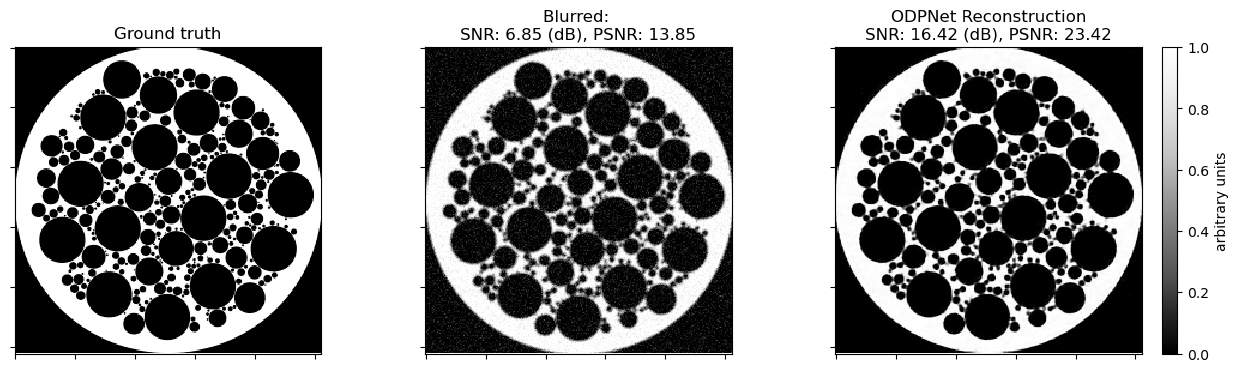

In [10]:
np.random.seed(123)
indx = np.random.randint(0, high=maxn)

fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(test_ds["label"][indx, ..., 0], title="Ground truth", cbar=None, fig=fig, ax=ax[0])
plot.imview(
    test_ds["image"][indx, ..., 0],
    title="Blurred: \nSNR: %.2f (dB), PSNR: %.2f"
    % (
        metric.snr(test_ds["label"][indx, ..., 0], test_ds["image"][indx, ..., 0]),
        metric.psnr(test_ds["label"][indx, ..., 0], test_ds["image"][indx, ..., 0]),
    ),
    cbar=None,
    fig=fig,
    ax=ax[1],
)
plot.imview(
    output[indx, ..., 0],
    title="ODPNet Reconstruction\nSNR: %.2f (dB), PSNR: %.2f"
    % (
        metric.snr(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
        metric.psnr(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
    ),
    fig=fig,
    ax=ax[2],
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[2].get_images()[0], cax=cax, label="arbitrary units")
fig.show()

Plot convergence statistics. Statistics are generated only if a training
cycle was done (i.e. if not reading final epoch results from checkpoint).

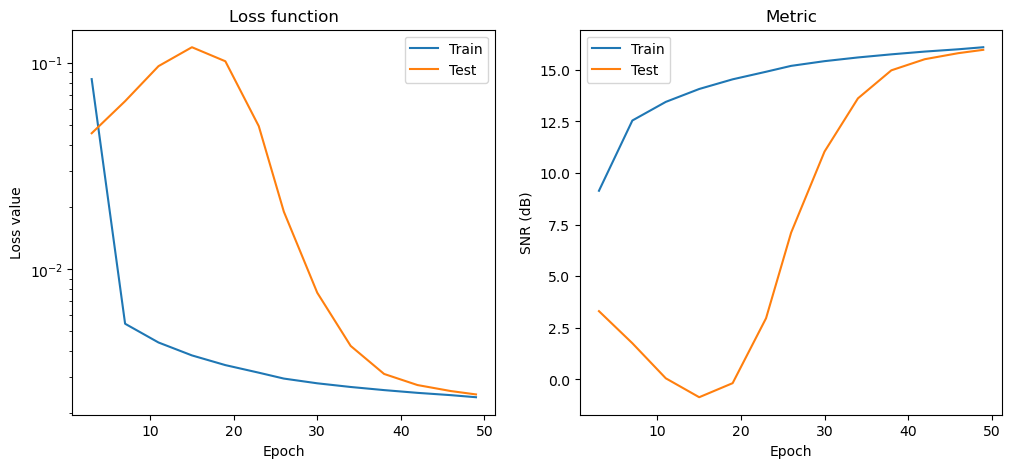

In [11]:
if stats_object is not None and len(stats_object.iterations) > 0:
    hist = stats_object.history(transpose=True)
    fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plot.plot(
        np.vstack((hist.Train_Loss, hist.Eval_Loss)).T,
        x=hist.Epoch,
        ptyp="semilogy",
        title="Loss function",
        xlbl="Epoch",
        ylbl="Loss value",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[0],
    )
    plot.plot(
        np.vstack((hist.Train_SNR, hist.Eval_SNR)).T,
        x=hist.Epoch,
        title="Metric",
        xlbl="Epoch",
        ylbl="SNR (dB)",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[1],
    )
    fig.show()